In [ ]:
!pip install -q torch_geometric lightning wandb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import numpy as np
import glob
import os
from tqdm import tqdm
import csv
import random
import h5py
import sys

from torch.profiler import profile, record_function, ProfilerActivity

import torch.nn.functional as F
import scipy.io as sio

from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_max_pool
from torch_geometric.data import Data
import lightning as L

from torch_geometric.loader import DataLoader

import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

import wandb

import matplotlib.pyplot as plt
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data


from torchmetrics.classification import MulticlassF1Score

In [ ]:
fs = 590 #Sampling frequency
n_ecogs = 31 #number of ecog channels
window_duration = 3 #seconds

In [ ]:
y = np.load('/content/drive/MyDrive/Colab Notebooks/INL/processed_data/label2.npy')
X_train =  np.load('/content/drive/MyDrive/Colab Notebooks/INL/processed_data/X_train2.npy')
X_train = X_train.reshape(-1, n_ecogs * window_duration, fs)

y_test = np.load('/content/drive/MyDrive/Colab Notebooks/INL/processed_data/label_test.npy')
X_test =  np.load('/content/drive/MyDrive/Colab Notebooks/INL/processed_data/X_test.npy')
X_test = X_test.reshape(-1, n_ecogs * window_duration, fs)

In [ ]:
X_train.shape

(11730, 93, 590)

In [ ]:
label_dict = {0: 'state__idle',
           1: 'state__shoulder__flexion',
           2: 'state__elbow__extension',
           3: 'state__wrist__pronation',
           4: 'state__wrist__supination',
           5: 'state__hand__open',
           6: 'state__hand__close',
          }

In [ ]:
dataset = []

for idx in tqdm(range(X_train.shape[0])):
    eeg_clip = X_train[idx,:,:]
    label = y[idx]
    if label == 7: #ignore label 7, which produces weird results
        continue
    dataset.append((torch.tensor(eeg_clip).float(), torch.tensor((label), dtype=torch.long)))

random.shuffle(dataset)


dataset_test = []

for idx in tqdm(range(X_test.shape[0])):
    eeg_clip = X_test[idx,:,:]
    label = y_test[idx]
    if label == 7: #ignore label 7
        continue
    dataset_test.append( ( torch.tensor(eeg_clip).float(), torch.tensor((label) , dtype=torch.long) ) )

random.shuffle(dataset_test)

100%|██████████| 2237/2237 [00:00<00:00, 5658.89it/s]


In [ ]:
dataset[0]

(tensor([[21.8461, 24.5043, 26.2765,  ..., 28.9347, 26.2765, 21.8461],
         [20.0740, 13.8713, 13.8713,  ..., 31.5929, 29.8208, 33.3651],
         [28.9347, 27.1626, 27.1626,  ..., 28.9347, 30.7069, 28.9347],
         ...,
         [32.0085, 31.1332, 28.5071,  ..., 22.3795, 18.8782, 19.7535],
         [19.7535, 18.0028, 21.5043,  ..., 32.0085, 32.0085, 34.6345],
         [32.8839, 35.5099, 34.6345,  ..., 34.6345, 36.3853, 35.5099]]),
 tensor(2))

In [ ]:
train_dataloader = DataLoader(dataset , batch_size = 64  )
test_dataloader = DataLoader(dataset_test , batch_size = 64   )

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """Attention Block.

        Args:
            embed_dim: Dimensionality of input and attention feature vectors
            hidden_dim: Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads: Number of heads to use in the Multi-Head Attention block
            dropout: Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_t_pints,
        num_heads,
        num_layers,
        num_classes,
        num_patches,
        dropout=0.0,
    ):
        """Vision Transformer.

        Args:
            embed_dim: Dimensionality of the input feature vectors to the Transformer
            hidden_dim: Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels: Number of channels of the input (3 for RGB)
            num_heads: Number of heads to use in the Multi-Head Attention block
            num_layers: Number of layers to use in the Transformer
            num_classes: Number of classes to predict
            patch_size: Number of pixels that the patches have per dimension
            num_patches: Maximum number of patches an image can have
            dropout: Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()



        self.input_layer = nn.Linear(num_t_pints, embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        # Preprocess input

        x = torch.log( torch.abs( torch.fft.fft(x , dim=-1) ) + 1e-10 )

        #x = torch.cat( [torch.log(torch.abs( torch.fft.fft(x , dim=-1).imag[:,:,0:295]))  , torch.log(torch.abs(torch.fft.fft(x , dim=-1).real[:,:,0:295]) ) ] , dim=-1)

        x = (x - x.mean(dim=-1 , keepdim=True) )/x.std(dim=-1 , keepdim=True)

        B, T, _ = x.shape # B Batch
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:, : T + 1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [ ]:
class ViT(L.LightningModule):
    def __init__(self, model_kwargs):
        super().__init__()

        self.model = VisionTransformer(**model_kwargs)


    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):

        optimizer = optim.Adam(params=self.parameters(),
                            lr = 1e-3)

        scheduler = CosineAnnealingLR(optimizer, T_max = 50)

        return [optimizer], [{"scheduler": scheduler, "interval": "epoch"}]


    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)

        # wandb.log({ "Bridge-GPT-Loss": loss})

        return loss


In [ ]:
model_kwargs={
        "embed_dim": 64,
        "hidden_dim": 64,
        "num_heads": 8,
        "num_layers": 4,
        "num_t_pints": 590,
        "num_patches": 93,
        "num_classes": 7,
        "dropout": 0.2,
    }

model = ViT(model_kwargs)

In [ ]:
trainer = L.Trainer(max_epochs= 50 , devices= 1, accelerator="gpu")

trainer.fit(model, train_dataloader )

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | VisionTransformer | 145 K  | train
----------------------------------------------------
145 K     Trainable params
0         Non-trainable params
145 K     Total params
0.581     Total estimated model params size (MB)
51        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type              | Params | M

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
import pytorch_lightning

torch.seed()
np.random.seed(120)
random.seed(123)
pytorch_lightning.utilities.seed

model.to('cuda')
l = [] #labels
gt = [] #ground thruth

for data in (tqdm(test_dataloader)):

    out = model(data[0].to('cuda'))

    l.extend(out.to('cpu').detach().numpy())

    gt.extend(( data[1].type(torch.float32).reshape(-1,1).to('cpu') ).detach().numpy())

100%|██████████| 35/35 [00:00<00:00, 83.23it/s]


In [ ]:
from torchmetrics.classification import MulticlassConfusionMatrix

target = torch.tensor( np.array(gt).reshape(-1,) )
label =   torch.squeeze( torch.tensor( np.array(l)) )

metric = MulticlassConfusionMatrix(num_classes=7)

c = np.array(metric(torch.argmax(label,-1) , target))

In [ ]:
c

array([[1247,   25,   26,   34,   12,   38,   34],
       [   6,   21,   26,    0,    0,    0,    1],
       [  21,    9,  131,    8,    2,    6,   16],
       [  26,    0,   12,   56,    0,   20,   25],
       [   0,    0,    0,    1,    0,    0,    0],
       [  54,    1,   20,   21,    0,   88,   39],
       [  47,    1,   29,   38,    1,   46,   31]])

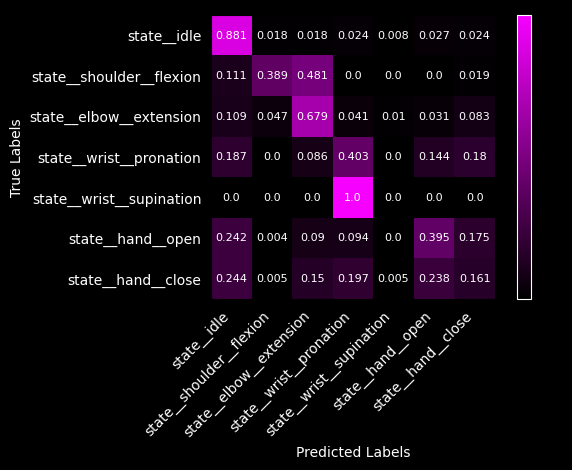

In [ ]:
# import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

C = c

colors = ['k' , '#F601FF'] # first color is black, last is red
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=200)

class_labels = [0, 1, 2, 3, 4, 5, 6]

normalized_confusion_matrix =  np.round(C/ np.sum(C, axis=1, keepdims=True), 3)

fig, ax = plt.subplots(facecolor='k')
im = ax.imshow(normalized_confusion_matrix , cmap = cm , vmin=0, vmax=1)
cb = fig.colorbar(im , ax=ax)
cb.outline.set_edgecolor('w')

ax.set_xlabel("Predicted Labels", color='w')
ax.set_ylabel("True Labels", color='w')

ax.set_xticks(np.arange(len(class_labels)), labels=[name for _, name in  label_dict.items()], color='w', rotation=45, ha='right')
ax.set_yticks(np.arange(len(class_labels)), labels=[name for _, name in  label_dict.items()], color='w')




for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text = ax.text(j, i, normalized_confusion_matrix[i, j],
                        ha="center", va="center", color="w" , size=8)


fig.tight_layout()
plt.show()